# Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
# %pip install kagglehub
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("arashnic/uplift-modeling")
path = r"C:\Users\nicho\.cache\kagglehub\datasets\arashnic\uplift-modeling\versions\1\criteo-uplift-v2.1.csv"

# Criteo AI Lab Dataset

I will use the Criteo AI Lab dataset to simulate customer data.
Source: https://www.kaggle.com/datasets/arashnic/uplift-modeling
> The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.
* f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
* treatment: treatment group (1 = treated, 0 = control)
* conversion: whether a conversion occured for this user (binary, label)
* * did the customer buy a grill?
* visit: whether a visit occured for this user (binary, label)
* * did teh customer visit our site?
* exposure: treatment effect, whether the user has been effectively exposed (binary)
* * whether the customer actually saw the banner ad or not

# EDA

In [4]:
df=pd.read_csv(path)

In [5]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [7]:
df["treatment"].value_counts()

treatment
1    11882655
0     2096937
Name: count, dtype: int64

Checking for feature imbalance

In [8]:
df[df["treatment"]==1].describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,1.188266e+07,11882655.0,1.188266e+07,1.188266e+07,1.188266e+07
mean,1.961476e+01,1.007034e+01,8.446302e+00,4.169412e+00,1.033925e+01,4.026602e+00,-4.182792e+00,5.105555e+00,3.933392e+00,1.605259e+01,5.333660e+00,-1.709848e-01,1.0,3.089461e-03,4.854336e-02,3.603673e-02
std,5.375564e+00,1.066934e-01,2.990746e-01,1.352432e+00,3.441166e-01,4.370446e-01,4.600940e+00,1.212461e+00,5.686911e-02,7.056251e+00,1.688467e-01,2.289462e-02,0.0,5.549700e-02,2.149114e-01,1.863816e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.376438e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.191727e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.442561e+01,1.005965e+01,8.720795e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.0,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.036660e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.0,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
df[df["treatment"]==0].describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2.096937e+06,2096937.0,2.096937e+06,2.096937e+06,2096937.0
mean,1.965170e+01,1.006794e+01,8.448173e+00,4.232821e+00,1.033653e+01,4.039339e+00,-3.999880e+00,5.080284e+00,3.934652e+00,1.588625e+01,5.331898e+00,-1.708677e-01,0.0,1.937588e-03,3.820096e-02,0.0
std,5.388112e+00,9.298990e-02,3.006762e-01,1.242029e+00,3.386814e-01,3.955382e-01,4.441985e+00,1.163292e+00,5.544518e-02,6.802162e+00,1.646757e-01,2.247879e-02,0.0,4.397539e-02,1.916811e-01,0.0
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-7.815454e+00,-2.930620e+01,4.833815e+00,3.640503e+00,1.319006e+01,5.300375e+00,-1.329638e+00,0.0,0.000000e+00,0.000000e+00,0.0
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.359690e+00,4.833815e+00,3.915574e+00,1.319006e+01,5.300375e+00,-1.686792e-01,0.0,0.000000e+00,0.000000e+00,0.0
50%,2.195963e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,0.0,0.000000e+00,0.000000e+00,0.0
75%,2.449624e+01,1.005965e+01,8.731431e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,0.0,0.000000e+00,0.000000e+00,0.0
max,2.674526e+01,1.560040e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199839e+01,3.971858e+00,6.772867e+01,6.473914e+00,-1.686792e-01,0.0,1.000000e+00,1.000000e+00,0.0


Finding correlations

In [10]:
features = [f'f{i}' for i in range(12)]
# comparing means of treatment vs control
stats = df.groupby('exposure')[features].mean().T
stats['diff'] = (stats[1] - stats[0]).abs()
print("potential bias:")
print(stats['diff'].sort_values(ascending=False))


potential bias:
f9     8.426524
f6     7.133638
f0     3.848126
f3     2.881347
f7     1.047835
f5     0.570762
f4     0.312714
f1     0.114475
f10    0.099097
f8     0.066906
f11    0.017431
f2     0.008316
Name: diff, dtype: float64


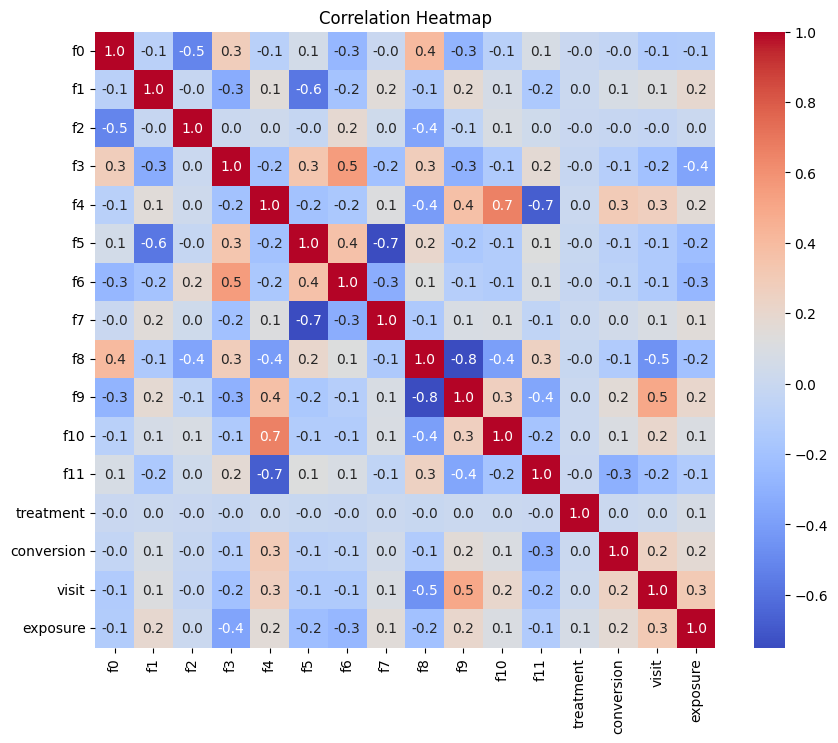

In [11]:
# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

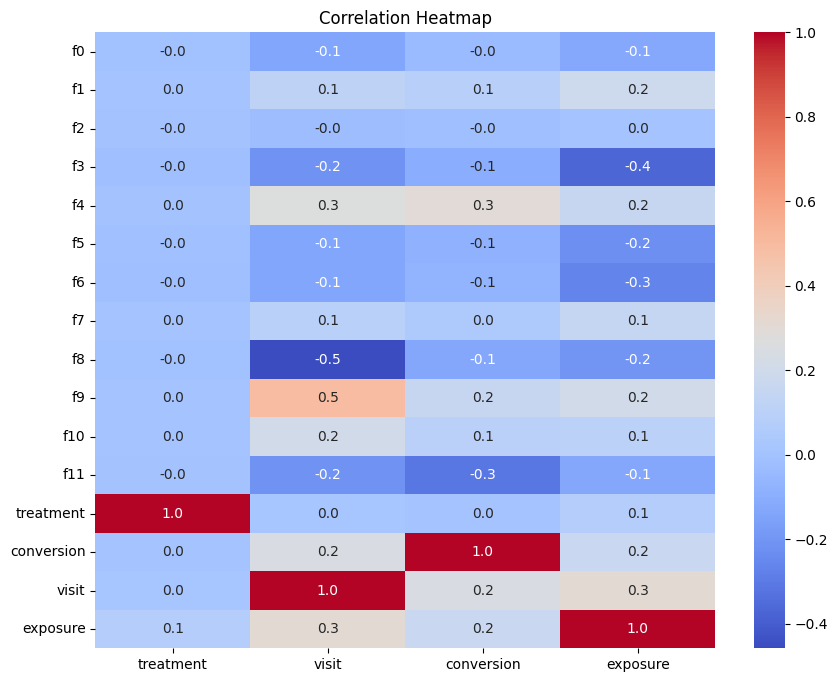

In [12]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr[['treatment','visit', 'conversion', 'exposure']], annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

In [13]:
corr

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
f0,1.000000,-0.086022,-0.514555,0.280570,-0.093442,0.053413,-0.270590,-0.000088,0.404888,-0.291799,-0.091798,0.078254,-0.002454,-0.037973,-0.134034,-0.123310
f1,-0.086022,1.000000,-0.012844,-0.329413,0.149221,-0.574309,-0.192257,0.151326,-0.143599,0.174166,0.069124,-0.150227,0.008185,0.083103,0.112029,0.188304
f2,-0.514555,-0.012844,1.000000,0.006777,0.024577,-0.022430,0.183739,0.035471,-0.372912,-0.051673,0.088896,0.030912,-0.002233,-0.014175,-0.030331,0.004787
f3,0.280570,-0.329413,0.006777,1.000000,-0.199666,0.334220,0.549706,-0.204964,0.282054,-0.303108,-0.135873,0.171959,-0.016939,-0.104222,-0.207821,-0.371455
f4,-0.093442,0.149221,0.024577,-0.199666,1.000000,-0.197011,-0.159261,0.112939,-0.409904,0.364326,0.658277,-0.677701,0.002829,0.298634,0.267452,0.156960
f5,0.053413,-0.574309,-0.022430,0.334220,-0.197011,1.000000,0.362113,-0.746508,0.201885,-0.159930,-0.126846,0.122037,-0.010549,-0.086751,-0.138319,-0.228143
f6,-0.270590,-0.192257,0.183739,0.549706,-0.159261,0.362113,1.000000,-0.323578,0.118972,-0.106988,-0.123118,0.089329,-0.014267,-0.071954,-0.137480,-0.268516
f7,-0.000088,0.151326,0.035471,-0.204964,0.112939,-0.746508,-0.323578,1.000000,-0.143521,0.087290,0.095967,-0.050098,0.007487,0.043745,0.091858,0.149811
f8,0.404888,-0.143599,-0.372912,0.282054,-0.409904,0.201885,0.118972,-0.143521,1.000000,-0.750324,-0.401546,0.253150,-0.007940,-0.130566,-0.457967,-0.203478
f9,-0.291799,0.174166,-0.051673,-0.303108,0.364326,-0.159930,-0.106988,0.087290,-0.750324,1.000000,0.267429,-0.362990,0.008462,0.156245,0.495268,0.206872


* treatment has near 0 correlations so no features had a dependency on the experiment
* features f4 and f9 seem to likely influence visits and conversion
* * f11 seems to influnce no conversion with negative correlation
* high +/- correlation between f8 and f9, f5 and f7, f4 and f10/f11

In [14]:

# Compare Conversion Rates
conversion_rates = df.groupby('exposure')['conversion'].mean()
print(f"Control: {conversion_rates[0]:.2%}")
print(f"Treatment: {conversion_rates[1]:.2}")
print(f"Raw Lift: {conversion_rates[1] - conversion_rates[0]:.2%}")

Control: 0.13%
Treatment: 0.054
Raw Lift: 5.25%


# Causal Inference Models

Here I will try out 3 common meta-learners that are popular in causal inference estimation:
* S Learner - a single model that includes the treatment as a feature in the model to predict conversion. The difference in scores between the treated and control group is the estimated uplaif score
* T Learner - a two model approach: one for the treatment group and one for the control group. The difference between the model ouptuts are the estimated uplift score
* X Learner - a more complex T Learner. You start with the two models for treatment and control, then impute the treatment effect for both groups. Then a second stage of learners are applied to predict these effects. The purpose is to guess what would have happened if a treated user had not seen the treatment, and if a control user had seen the treatment, and calculate the imputed uplift score on these scenarios.

## S Learner

### XGBoost

Popular boosted tree model best for large datassets

In [18]:
# Need to take treatment effects into account when model learns across user behaviors 
# create interaction features by mutliplying treatment outcome with feature list
# interactions will be zero for control group (since no treatment occured) 
for f in features:
    df[f'{f}_int'] = df[f] * df['treatment']

# Updated feature list including interactions
all_features = features + ['treatment'] + [f'{f}_int' for f in features]

# 4. Split and Train the S-Learner
X = df[all_features]
y = df['conversion']
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

s_learner = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
s_learner.fit(X_train, y_train)

# copy and apply learner for treatemnt and control data subsets
X_test_treated = X_test.copy()
X_test_treated['treatment'] = 1
for f in features:
    X_test_treated[f'{f}_int'] = X_test_treated[f] * 1

X_test_control = X_test.copy()
X_test_control['treatment'] = 0
for f in features:
    X_test_control[f'{f}_int'] = X_test_control[f] * 0

prob_treated = s_learner.predict_proba(X_test_treated)[:, 1]
prob_control = s_learner.predict_proba(X_test_control)[:, 1]

In [19]:

uplift_score = prob_treated - prob_control
X_test['uplift_score'] = uplift_score
print(f"Treatment: {prob_treated}, Control: {prob_control}, Uplift: {uplift_score}")
print(f"Mean Uplift Score: {uplift_score.mean():.5f}")

Treatment: [3.8019598e-03 6.8402973e-05 4.5780270e-04 ... 5.7393382e-04 2.7817951e-03
 1.0747719e-04], Control: [2.5015278e-03 4.6920697e-05 2.6442989e-04 ... 5.2288006e-04 2.1167344e-03
 6.1358754e-05], Uplift: [1.3004320e-03 2.1482276e-05 1.9337281e-04 ... 5.1053765e-05 6.6506071e-04
 4.6118439e-05]
Mean Uplift Score: 0.00098


The 0.00098 score is our average treatment effect. As a percentage (0.098%), this translates to  ~0.1%, saying that for every 1K customers we expose the treatement to, we can possibly gain 1 additional conversion. 1 million impressions on our banner ad could give us 1000 more grill purchasers vs those who didnt see the ad.

Our previous raw lift was 5.25%. Dividing 5.25% by the 0.098% gives a relative increase of ~20% in sales.

### Deciles

Looking at this in a standard decile view of scores instead of an avg

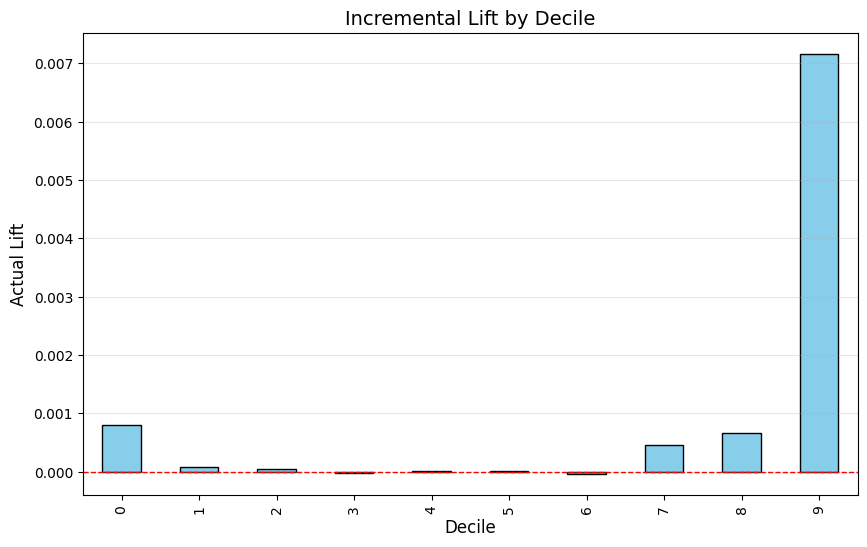

treatment  actual_lift
decile                
0             0.000796
1             0.000081
2             0.000044
3            -0.000029
4             0.000004
5             0.000006
6            -0.000039
7             0.000450
8             0.000667
9             0.007165


In [33]:
X_test_results = X_test.copy()
X_test_results['actual_conversion'] = y_test.values
X_test_results['decile'] = pd.qcut(X_test_results['uplift_score'], 10, labels=False)
analysis = X_test_results.groupby(['decile', 'treatment'])['actual_conversion'].mean().unstack()

# lift per decile (treatment - control)
analysis['actual_lift'] = analysis[1] - analysis[0]

plt.figure(figsize=(10, 6))
analysis['actual_lift'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Incremental Lift by Decile', fontsize=14)
plt.xlabel('Decile', fontsize=12)
plt.ylabel('Actual Lift', fontsize=12)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(analysis[['actual_lift']])

* With decile 9, the top 10% of customers are about 7x more responsive to the ad than our avg customer base. Targeting these customers would generate the highest ROI for our campaign with a major reduction in ad spend.
* Deciles 3 and 6 were slighly negative - these customers were less likely to convert vs not being showed an ad at all. These customers should be avoided in the future campaign

## T Learner

### XGBoost

In [20]:
# No interaction features for T learner
features = [f'f{i}' for i in range(12)]
all_features = features + ['treatment']

X = df[all_features]
y = df['conversion']
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# treatment and control training sets
X_train_treat = X_train[X_train['treatment'] == 1][features]
y_train_treat = y_train[X_train['treatment'] == 1]

X_train_ctrl = X_train[X_train['treatment'] == 0][features]
y_train_ctrl = y_train[X_train['treatment'] == 0]

model_t = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
model_t.fit(X_train_treat, y_train_treat)

model_c = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
model_c.fit(X_train_ctrl, y_train_ctrl)

# pass test sets to both models
prob_t = model_t.predict_proba(X_test[features])[:, 1]
prob_c = model_c.predict_proba(X_test[features])[:, 1]

# uplift score
t_learner_uplift = prob_t - prob_c
X_test['uplift_t_learner'] = t_learner_uplift

print(f"Treatment: {prob_t}, Control: {prob_c}, Uplift: {t_learner_uplift}")
print(f"Mean Uplift Score: {t_learner_uplift.mean():.5f}")

Treatment: [3.7735272e-03 7.1621987e-05 5.0359737e-04 ... 5.6038296e-04 2.8139264e-03
 1.2588633e-04], Control: [2.4397389e-03 3.5376623e-05 2.8089946e-04 ... 4.3720542e-04 1.6429940e-03
 7.5229982e-05], Uplift: [1.3337883e-03 3.6245365e-05 2.2269791e-04 ... 1.2317754e-04 1.1709324e-03
 5.0656352e-05]
Mean Uplift Score: 0.00102


### Deciles

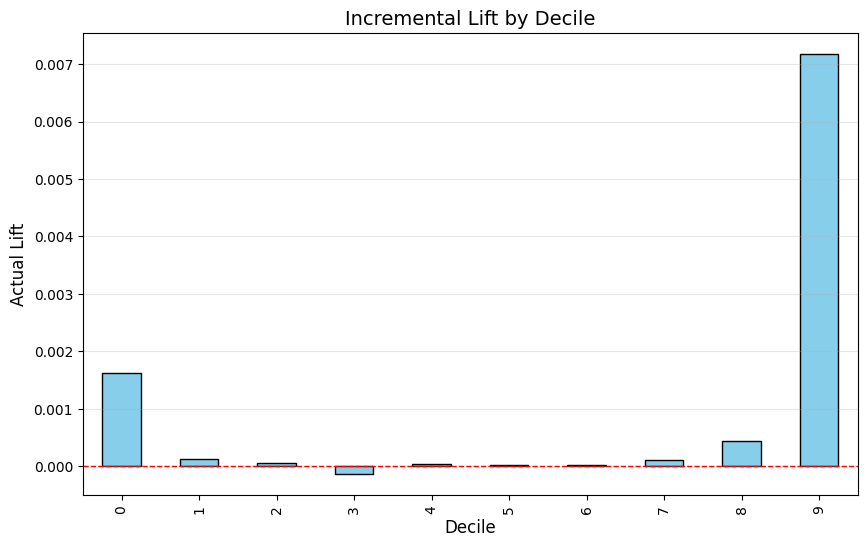

treatment  actual_lift
decile                
0             0.001624
1             0.000133
2             0.000063
3            -0.000131
4             0.000047
5             0.000029
6             0.000017
7             0.000117
8             0.000436
9             0.007177


In [22]:
X_test_results = X_test.copy()
X_test_results['actual_conversion'] = y_test.values
X_test_results['decile'] = pd.qcut(X_test_results['uplift_t_learner'], 10, labels=False)
analysis = X_test_results.groupby(['decile', 'treatment'])['actual_conversion'].mean().unstack()

# lift per decile (treatment - control)
analysis['actual_lift'] = analysis[1] - analysis[0]

plt.figure(figsize=(10, 6))
analysis['actual_lift'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Incremental Lift by Decile', fontsize=14)
plt.xlabel('Decile', fontsize=12)
plt.ylabel('Actual Lift', fontsize=12)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(analysis[['actual_lift']])

* The T learner's avg uplift score of 0.00102 is very close to the s learner's 0.00098 score. And since they both produced a high lift of 0.007 for decile 9, this gives us more confidence that the customers in this group are our most valuable base for our campaign.
* Decile 0 has a higher lift than expected. Most likely from the imbalance of data between control and treatment - control was only 15% of the total population, so it's possible that the model overfit on the smaller sample. 
* * But given that the uplift scores were similar to S learner's , I would still feel comfortable moving forward with this output

## X Learner

The X learner will take the two models from the T learner stage and "refine" by imputing treatment effects. Basically, we are creating a fake outcome on how likely each customer would have converted based on being in the oppositie group. This leads to an estimated incremental uplift for each customer in our data, instead of just predicting conversion like the previous 2 learners.

### XGBoost

In [ ]:
# use train/test data and models from t learner section
# still sue treatement - control

# Treatment Group: Actual - Control Model prediction
X_treat = X_train[X_train['treatment'] == 1][features]
y_treat = y_train[X_train['treatment'] == 1]
D_treat = y_treat - model_c.predict_proba(X_treat)[:, 1]

# Control Group: Treatment Model prediction - Actual
X_ctrl = X_train[X_train['treatment'] == 0][features]
y_ctrl = y_train[X_train['treatment'] == 0]
D_ctrl = model_t.predict_proba(X_ctrl)[:, 1] - y_ctrl

# two new models now predict on D_treat and D_ctrl
# use regression since we're dealing with continuous values

model_t_2 = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model_t_2.fit(X_treat, D_treat)

model_c_2 = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model_c_2.fit(X_ctrl, D_ctrl)

# go with dataset's 85% treatment sample for weighted avg
propensity = 0.85 

# predictions
tau_t_preds = model_t_2.predict(X_test[features])
tau_c_preds = model_c_2.predict(X_test[features])
X_test['uplift_x_learner'] = (propensity * tau_c_preds) + ((1 - propensity) * tau_t_preds)

print(f"X-Learner Mean Uplift Score: {X_test['uplift_x_learner'].mean():.5f}")

X-Learner Mean Uplift: 0.00100


### Deciles

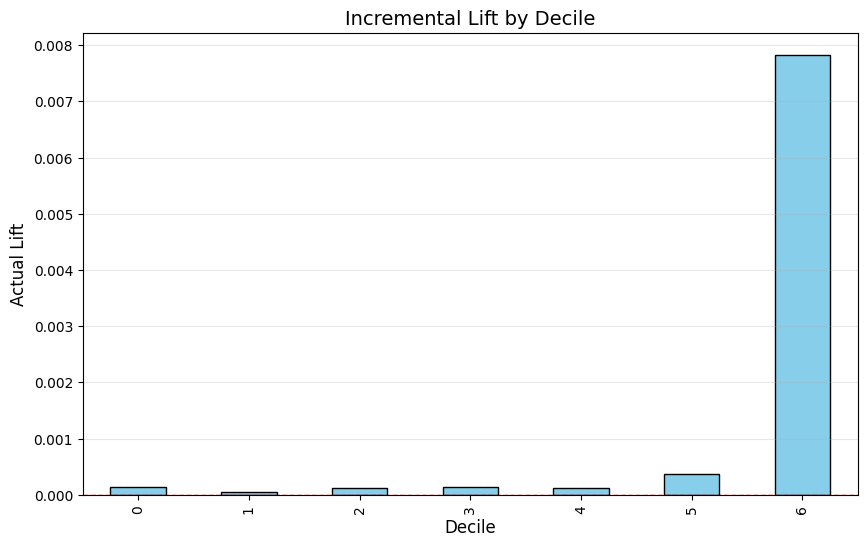

treatment  actual_lift
decile                
0             0.000146
1             0.000049
2             0.000121
3             0.000131
4             0.000127
5             0.000370
6             0.007830


In [ ]:
X_test_results = X_test.copy()
X_test_results['actual_conversion'] = y_test.values
X_test_results['decile'] = pd.qcut(X_test_results['uplift_x_learner'], 10, labels=False,duplicates='drop') 
# drop duplicates for users with the same scores, which will lessen the number of bins for decile rankings
analysis = X_test_results.groupby(['decile', 'treatment'])['actual_conversion'].mean().unstack()

# lift per decile (treatment - control)
analysis['actual_lift'] = analysis[1] - analysis[0]

plt.figure(figsize=(10, 6))
analysis['actual_lift'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Incremental Lift by Decile', fontsize=14)
plt.xlabel('Decile', fontsize=12)
plt.ylabel('Actual Lift', fontsize=12)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(analysis[['actual_lift']])

* X learner's average uplift score of 0.001 agrees with the S and T learners. It was more effective at identifying customers who would likely drive conversion by reducing the population to 6 deciles. The customers who would be indifferent or respond negatively are pushed out to the lower bins.
* The lower decile 0 bar also suggests that the X learner effectively reduced noise during its predictions

# Results / Discussion

* Our average treatment effect is ~0.1% for the total population in the Criteo dataset
* Our top decile has an actual lift of 0.78%
* This means our top group of customers is nearly 8 times more responsive to our ad than the average customer. This will give us a significant ROI when reducing ad spend to this group alone.

Below are counts to size this impact

In [37]:
top_segment_count = X_test_results[X_test_results['decile'] == 6].shape[0]
total_population = X_test_results.shape[0]
perc_of_total = (top_segment_count / total_population) * 100

# Incremental Impact
lift_val = 0.00783
incremental_sales = lift_val * top_segment_count

print(f"Users in Top Segment (Decile 6): {top_segment_count:,}")
print(f"Total Users: {total_population:,}")
print(f"This segment represents: {perc_of_total:.2f}% of population")
print(f"Incremental Sales/Conversion from this group: {incremental_sales:.2f}")

Users in Top Segment (Decile 6): 279,265
Total Users: 2,795,919
This segment represents: 9.99% of population
Incremental Sales/Conversion from this group: 2186.64


By targeting only this top 10%, the business generates 2,186 incremental conversions with a 90% reduction in ad spend.

## Qini Curve

A Qini curve evaluates the model by showing us the cumulative uplift/gain from using our X learner vs a random apporach of targeting all customers

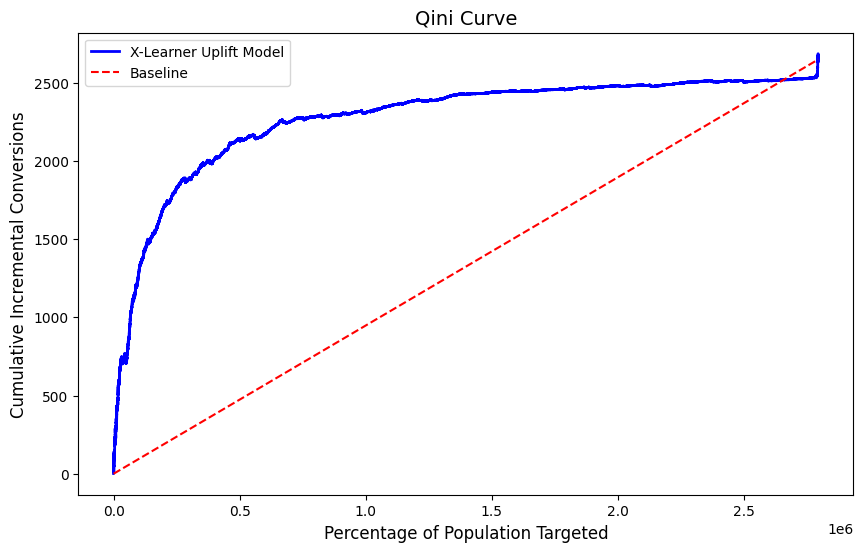

In [42]:
def plot_qini_curve(df, uplift_col, target_col, treatment_col):

    df_sorted = df.sort_values(by=uplift_col, ascending=False).reset_index(drop=True)
    
    # cumulative values
    df_sorted['n_treated'] = df_sorted[treatment_col].cumsum()
    df_sorted['n_control'] = (1 - df_sorted[treatment_col]).cumsum()
    
    df_sorted['ups_treated'] = (df_sorted[target_col] * df_sorted[treatment_col]).cumsum()
    df_sorted['ups_control'] = (df_sorted[target_col] * (1 - df_sorted[treatment_col])).cumsum()
    
    # Qini Formula: Treated_Conversions - (Control_Conversions * n_Treated / n_Control)
    qini = df_sorted['ups_treated'] - (df_sorted['ups_control'] * df_sorted['n_treated'] / (df_sorted['n_control'] + 1e-10))
    # make a baseline straight line from (0,0) to the final Qini value
    baseline = np.linspace(0, qini.iloc[-1], len(qini))
    
    plt.figure(figsize=(10, 6))
    plt.plot(qini.values, label='X-Learner Uplift Model', color='blue', lw=2)
    plt.plot(baseline, label='Baseline', color='red', linestyle='--')
    plt.title('Qini Curve', fontsize=14)
    plt.xlabel('Percentage of Population Targeted', fontsize=12)
    plt.ylabel('Cumulative Incremental Conversions', fontsize=12)
    plt.legend()
    plt.show()


plot_qini_curve(X_test_results, 'uplift_x_learner', 'actual_conversion', 'treatment')

The area under the curve between the random baseline targeting represents the total gain added by our X learner. It also shows the diminishing returns after we go past targeting our top % of customers from decile 6.

# References / Inspiration:
* https://medium.com/data-reply-it-datatech/uplift-modeling-predict-the-causal-effect-of-marketing-communications-24385fb04f2e
* https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html#meta-learners
* https://grf-labs.github.io/grf/articles/maq.html